#Movie Recommender System

In [ ]:
# Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from random import randrange
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

pd.options.mode.chained_assignment = None 

In [ ]:
from google.colab import files

uploaded = files.upload() # Here we will upload the csv files for this problem

for fn in uploaded.keys():
  print('You uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving links.csv to links.csv
Saving movies.csv to movies.csv
Saving movies_metadata.csv to movies_metadata.csv
Saving ratings.csv to ratings.csv
You uploaded file "links.csv" with length 197979 bytes
You uploaded file "movies.csv" with length 494431 bytes
You uploaded file "movies_metadata.csv" with length 34445126 bytes
You uploaded file "ratings.csv" with length 2483723 bytes


### Input Data Pre-processing

In [ ]:
movies_df = pd.read_csv('movies.csv')
tmdb_df = pd.read_csv('links.csv')
ratings_df = pd.read_csv('ratings.csv')
movies_metadata = pd.read_csv('movies_metadata.csv')

In [ ]:
display(movies_df) 
display(tmdb_df) 

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [ ]:
tmdb_df = pd.merge(movies_df,tmdb_df,on='movieId')
tmdb_df.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [ ]:
display(ratings_df) 
display(movies_metadata) 

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,Fa

In [ ]:
movies_metadata.drop(columns = ['title', 'original_title', 'adult', 'homepage', 'original_language', 'budget', 
                                'belongs_to_collection', 'release_date', 'revenue', 'runtime', 'status', 'video', 
                                'poster_path', 'imdb_id', 'production_countries', 'spoken_languages','vote_average',
                                'vote_count'], inplace = True)
movies_metadata.rename(columns={'id': 'tmdbId'}, inplace=True)

movies_metadata.head()

,genres,tmdbId,overview,popularity,production_companies,tagline
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]",NaN
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",Roll the dice and unleash the excitement!
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",Still Yelling. Still Fighting. Still Ready for...
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",3.85949,[{'name': 'Twentieth Century Fox Film Corporat...,Friends are the people who let you be yourself...
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,8.38752,"[{'name': 'Sandollar Productions', 'id': 5842}...",Just When His World Is Back To Normal... He's ...


In [ ]:
movies_df.drop(columns = ['genres'], inplace = True)
for i in range(len(movies_metadata)):
    try:
        movies_metadata.loc[i, 'tmdbId'] = int(movies_metadata.loc[i, 'tmdbId'])
    except:
        print(i, movies_metadata.loc[i, 'tmdbId'])
movies_metadata = movies_metadata.drop([19730, 29503, 35587])
movies_df = pd.merge(tmdb_df,movies_metadata,on='tmdbId')
movies_df.drop(columns = ['imdbId','tmdbId'], inplace = True)
movies_df.head()

19730 1997-08-20
29503 2012-09-29
35587 2014-01-01


,movieId,title,genres_x,genres_y,overview,popularity,production_companies,tagline
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]",NaN
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",Roll the dice and unleash the excitement!
2,3,Grumpier Old Men (1995),Comedy|Romance,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",Still Yelling. Still Fighting. Still Ready for...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",3.85949,[{'name': 'Twentieth Century Fox Film Corporat...,Friends are the people who let you be yourself...
4,5,Father of the Bride Part II (1995),Comedy,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,8.38752,"[{'name': 'Sandollar Productions', 'id': 5842}...",Just When His World Is Back To Normal... He's ...


In [ ]:
movies_df['tagline'] = movies_df['tagline'].fillna('')
movies_df['overview'] = movies_df['overview'].fillna('')
movies_df['description'] = movies_df['overview'] + movies_df['tagline']
movies_df['description'] = movies_df['description'].fillna('')
movies_df.drop(columns = ['tagline', 'overview'], inplace = True)
movies_df

,movieId,title,genres_x,genres_y,popularity,production_companies,description
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",When siblings Judy and Peter discover an encha...
2,3,Grumpier Old Men (1995),Comedy|Romance,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",A family wedding reignites the ancient feud be...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.85949,[{'name': 'Twentieth Century Fox Film Corporat...,"Cheated on, mistreated and stepped on, the wom..."
4,5,Father of the Bride Part II (1995),Comedy,"[{'id': 35, 'name': 'Comedy'}]",8.38752,"[{'name': 'Sandollar Productions', 'id': 5842}...",Just when George Banks has recovered from his ...
...,...,...,...,...,...,...,...
9550,175705,Themroc (1973),Comedy|Horror,"[{'id': 35, 'name': 'Comedy'}]",2.018911,"[{'name': 'Filmanthrope', 'id': 2170}, {'name'...","Made without proper language, just gibberish a..."
9551,175707,A German Life (2016),Documentary,"[{'id': 99, 'name': 'Documentary'}]",0.126064,"[{'name': 'Medienproduktion GmbH', 'id': 85450...","Brunhilde Pomsel describes herself as an ""apol..."
9552,175743,Self-criticism of a Bourgeois Dog (2017),Comedy,"[{'id': 35, 'name': 'Comedy'}]",0.079173,[],A bourgeois dog confesses how he was transform...
9553,175781,Der Herr Karl (1961),Comedy,"[{'id': 35, 'name': 'Comedy'}]",0.192235,"[{'name': 'Österreichischer Rundfunk (ORF)', '...",No overview found.


In [ ]:
ratings_df.drop(columns = ['timestamp'], inplace = True)
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
movies_metadata['tagline'].replace('', np.nan, inplace=True)
movies_metadata.dropna(subset=['tagline'], inplace=True)
movies_metadata['overview'].replace('', np.nan, inplace=True)
movies_metadata.dropna(subset=['overview'], inplace=True)
 
movies_metadata.head()

,genres,tmdbId,overview,popularity,production_companies,tagline
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",Roll the dice and unleash the excitement!
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",Still Yelling. Still Fighting. Still Ready for...
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",3.85949,[{'name': 'Twentieth Century Fox Film Corporat...,Friends are the people who let you be yourself...
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,8.38752,"[{'name': 'Sandollar Productions', 'id': 5842}...",Just When His World Is Back To Normal... He's ...
5,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,"Obsessive master thief, Neil McCauley leads a ...",17.9249,"[{'name': 'Regency Enterprises', 'id': 508}, {...",A Los Angeles Crime Saga


### Making cosine similarity matrix

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_df['description'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
tfidf_matrix2 = tf.fit_transform(movies_df['description'].sample(n=50))
cosine_sim2 = linear_kernel(tfidf_matrix2, tfidf_matrix2)

Correlation of 50 randomly sampled movies


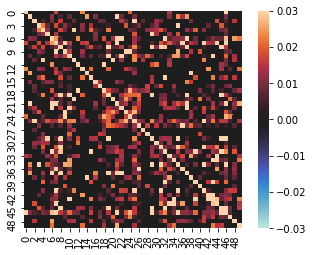

In [ ]:
print('Correlation of 50 randomly sampled movies')
ax = sns.heatmap(
    cosine_sim2, 
    vmin=-0.03, vmax=0.03, center=0,
    square=True
)


### Content based Recommendation System

In [ ]:
titles = movies_df['title']
indices = pd.Series(movies_df.index, index=movies_df['title'])
indices

title
Toy Story (1995)                                   0
Jumanji (1995)                                     1
Grumpier Old Men (1995)                            2
Waiting to Exhale (1995)                           3
Father of the Bride Part II (1995)                 4
                                                ... 
Themroc (1973)                                  9550
A German Life (2016)                            9551
Self-criticism of a Bourgeois Dog (2017)        9552
Der Herr Karl (1961)                            9553
LEGO DC Super Hero Girls: Brain Drain (2017)    9554
Length: 9555, dtype: int64

In [ ]:
def content_recommender(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices], sim_scores

In [ ]:
movieid = int(input("Enter Movie ID: "))

Enter Movie ID: 650


In [ ]:
random_movie = movieid
print('Content based Movie Recommendations for')
print(movies_df.loc[random_movie, 'title'])

rec_titles, rec_scores = content_recommender(random_movie)
print()
for i in range(5):
    print("{} with score: {}".format(rec_titles.iloc[i], rec_scores[i][1]))

Content based Movie Recommendations for
House Arrest (1996)

Story of Us, The (1999) with score: 0.06553508868739535
Fireproof (2008) with score: 0.06348084790174736
Let's Get Harry (1986) with score: 0.059787409052156834
Zack and Miri Make a Porno (2008) with score: 0.05928580639489695
Miami Rhapsody (1995) with score: 0.05337607804011512


### Item based Collaborative Recommender

In [ ]:
df = pd.merge(movies_df,ratings_df,on='movieId')
movie_ratings = pd.DataFrame()
movie_ratings['NumReviews'] = df.groupby('title')['rating'].count()
df = pd.merge(df,movie_ratings,on='title')
movie_ratings['Rating'] = df.groupby('title')['rating'].mean()
movie_ratings.sort_values(['NumReviews'],ascending=False).head()

,NumReviews,Rating
title,,
Forrest Gump (1994),329,4.164134
"Shawshank Redemption, The (1994)",317,4.429022
Pulp Fiction (1994),307,4.197068
"Silence of the Lambs, The (1991)",279,4.161290
"Matrix, The (1999)",278,4.192446


In [ ]:
mean_count = movie_ratings['NumReviews'].mean()
movieRatings = df.query('NumReviews >= @mean_count')
movieRatings.head()

,movieId,title,genres_x,genres_y,popularity,production_companies,description,userId,rating,NumReviews
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ...",1,4.0,215
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ...",5,4.0,215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ...",7,4.5,215
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ...",15,2.5,215
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ...",17,4.5,215


In [ ]:
matrix = movieRatings.pivot_table(columns='userId',index='title',values='rating').fillna(0)
matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(500) Days of Summer (2009),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
10 Cloverfield Lane (2016),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
"10,000 BC (2008)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


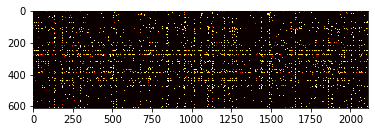

In [ ]:
plt.imshow(matrix.T, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
movie_vectors = csr_matrix(matrix.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'auto') 
model_knn.fit(movie_vectors)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
def collab_recommender(random_movie):
    distances, indices = model_knn.kneighbors(matrix.iloc[random_movie,:].values.reshape(1, -1), n_neighbors = 6)
    movies = []
    scores = []
    for i in range(0, len(distances.flatten())):
        if i == 0:
            continue
        else:
            movies.append(matrix.index[indices.flatten()[i]])
            scores.append(distances.flatten()[i])
    return movies, scores

In [ ]:
movieid = int(input("Enter Movie ID: ") )

Enter Movie ID: 700


In [ ]:
random_movie = movieid
print('Recommendations for {0}:\n'.format(matrix.index[random_movie]))
movies, scores = collab_recommender(random_movie)
for i in range(len(movies)):
    print('{}: {}, with distance of {}:'.format(i, movies[i], scores[i]))

Recommendations for Footloose (1984):

0: Far and Away (1992), with distance of 0.47536674777267973:
1: Cocktail (1988), with distance of 0.504603862687135:
2: Pelican Brief, The (1993), with distance of 0.5711160458858258:
3: Keeping the Faith (2000), with distance of 0.5848305904925661:
4: For Your Eyes Only (1981), with distance of 0.5911692600057153:


### Hybrid Recommender

In [ ]:
def final_recommendations(liked_movies):
    recommendations = []
    for mov in liked_movies:
        movie = -1
        for i in range(len(movies_df)):
            if movies_df.loc[i, 'title'] == mov:
                movie = i
                break
        movs1, scores1 = content_recommender(movie)
        movs1 = movs1.tolist()
        for i in range(len(matrix.index)):
            if matrix.index[i] == mov:
                movie = i
                break
        movs2, scores2 = collab_recommender(movie)
        recommendations.append(movs1[0])
        recommendations.append(movs2[0])
        
    return recommendations

### Testing

In [ ]:
userid = int(input("Enter your User ID: ") )

Enter your User ID: 10


In [ ]:
random_user = userid

liked_movies = matrix.iloc[:, random_user].sort_values(ascending=False).head().index.tolist()
print("User {} likes the movies:".format(random_user))
for m in liked_movies:
    print(m)
rec = final_recommendations(liked_movies)
print("\nMovie Recommendations for User {}:".format(random_user))
rec = list(dict.fromkeys(rec)) # Remove duplicate entries
for r in rec:
    print(r)

User 10 likes the movies:
Fugitive, The (1993)
Saving Private Ryan (1998)
Searching for Bobby Fischer (1993)
Titanic (1997)
Braveheart (1995)

Movie Recommendations for User 10:
Long Goodbye, The (1973)
True Lies (1994)
Bat*21 (1988)
Matrix, The (1999)
Pawn Sacrifice (2015)
Rudy (1993)
Raise the Titanic (1980)
Men in Black (a.k.a. MIB) (1997)
Certified Copy (Copie conforme) (2010)
Jurassic Park (1993)
